In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Parameters
DATA_PATH = "D:\Kuliah\praTa\\train\\train3"  # Replace with your dataset path
WINDOW_SIZE = 450  # Sliding window size (number of frames)
STEP_SIZE = 30     # Step size for the sliding window
LABELS = [1, 2, 3]  # Labels for the drowsiness levels

In [ ]:
# Function to load and preprocess data
def load_data(data_path, labels, window_size, step_size):
    sequences = []
    sequence_labels = []

    for label in labels:
        folder_path = os.path.join(data_path, str(label))
        files = os.listdir(folder_path)

        for file in files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, header=None)
            data = df[0].values  # Assuming the single column represents eye states (0 or 1)
            # print(len(data))

            # Apply sliding window
            for i in range(0, 7150 - window_size + 1, step_size):
                window = data[i:i + window_size]
                sequences.append(window)
                sequence_labels.append(label - 1)  # Convert label to zero-based index for categorical encoding

    return np.array(sequences), np.array(sequence_labels)

# Load data
X, y = load_data(DATA_PATH, LABELS, WINDOW_SIZE, STEP_SIZE)
print(X)
print(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

[[1 1 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]]
[0 0 0 ... 2 2 2]


In [ ]:
# # One-hot encode labels
# y = to_categorical(y, num_classes=len(LABELS))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.astype("float32") / 1.0
X_test = X_test.astype("float32") / 1.0


# # Convert labels to one-hot encoding for categorical cross-entropy
# y_train_onehot = to_categorical(y_train, num_classes=len(LABELS))
# y_test_onehot = to_categorical(y_test, num_classes=len(LABELS))

# # Reshape data for LSTM (samples, timesteps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train)

from collections import Counter
print(Counter(y_train))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

[[[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]
Counter({0: 1434, 1: 1433, 2: 1433})
X_train shape: (4300, 450, 1)
y_train shape: (4300,)
X_test shape: (1076, 450, 1)
y_test shape: (1076,)


In [ ]:
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\ULTRON\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 450, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,019 (148.51 KB)

 Trainable params: 38,019 (148.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model = load_model("drowsy_detection_gru.h5")  # Sesuaikan dengan nama file model Anda

In [ ]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=128,
    batch_size=128,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 729ms/step - accuracy: 0.3450 - loss: 1.1045 - val_accuracy: 0.3652 - val_loss: 1.0847 - learning_rate: 0.0050
Epoch 2/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 692ms/step - accuracy: 0.3752 - loss: 1.0876 - val_accuracy: 0.3383 - val_loss: 1.0867 - learning_rate: 0.0050
Epoch 3/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 699ms/step - accuracy: 0.3559 - loss: 1.0966 - val_accuracy: 0.3922 - val_loss: 1.1158 - learning_rate: 0.0050
Epoch 4/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 692ms/step - accuracy: 0.3531 - loss: 1.1511 - val_accuracy: 0.3336 - val_loss: 1.1088 - learning_rate: 0.0050
Epoch 5/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 694ms/step - accuracy: 0.3451 - loss: 1.1045 - val_accuracy: 0.3959 - val_loss: 1.0775 - learning_rate: 0.0050
Epoch 6/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 690ms/step - accuracy: 0.3938 - loss: 1.0819 - val_accuracy: 0.4480 - val_loss: 1.0648 - learning_rate: 0.0050
Epoch 7/128
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 693ms/step - accuracy: 0.4316 - l

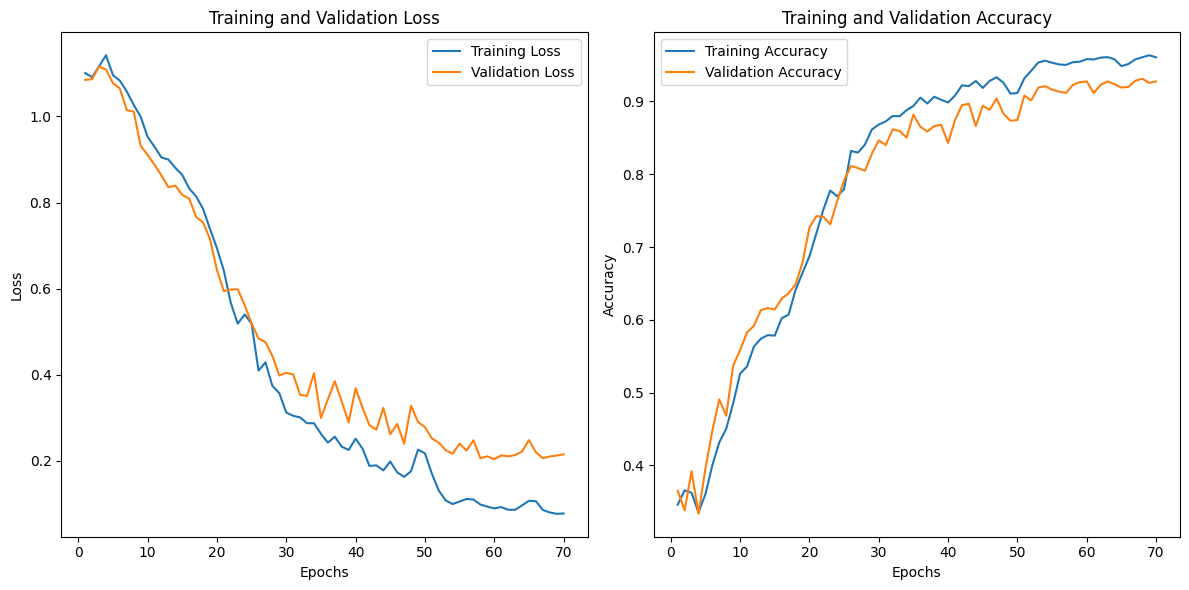

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and saved the history
# `history` is returned by model.fit()
# Example:
# history = model.fit(...)

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history.get('accuracy')  # 'accuracy' or 'categorical_accuracy' depending on your task
val_accuracy = history.history.get('val_accuracy')  # 'val_accuracy' or 'val_categorical_accuracy'

# Create epochs range
epochs_range = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot (if available)
if train_accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Predictions
y_pred_prob = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class labels if applicable

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

In [ ]:
# Save the model
# model.save("drowsy_detection_gru.h5")